In [39]:
import osrs_GE

import numpy as np
import pandas as pd

from datetime import datetime

import seaborn as sns

from osrs_GE import elliptic_paraboloid_loss as eploss

import matplotlib.pyplot as plt

#### To-do
- Algorithmic way of determining return thresholds for classification?
    - Should be solely based off of some trailing vol ema or updated every x days/intervals

In [40]:
# dragonfire shield
item_id = 11284
freq = '6h'


item_name = osrs_GE.item_name_from_id(item_id)
df = osrs_GE.read_item_master_file(item_id,freq)
df = osrs_GE.compute_VWAP(df)
df['simpRet_y'] = df['VWAP'].shift(-1)/df['VWAP'] - 1
df.head()

File read successfully for Master Files/items/master_file_11284_6h.csv


,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP
date,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06


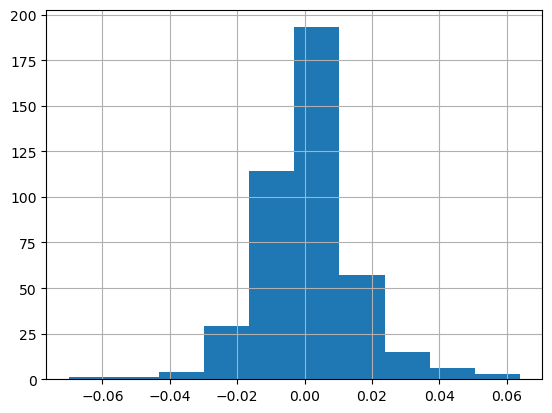

In [42]:
df['simpRet_y'].hist()
plt.show()

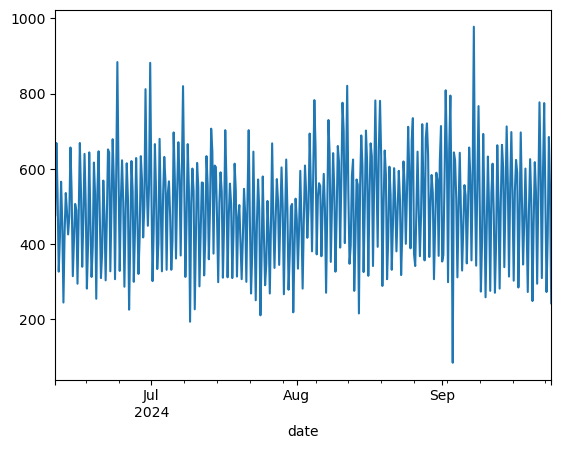

In [43]:
(df['highPriceVolume']+df['lowPriceVolume']).plot()
plt.show()

In [44]:
# create train test split
train_idx = int(.7*df.index.shape[0])
train_dt = df.index[train_idx]
df_tr = df[df.index < train_dt]
df_te = df[df.index >= train_dt]

print(df_tr.shape)
print(df_te.shape)

(296, 7)
(128, 7)


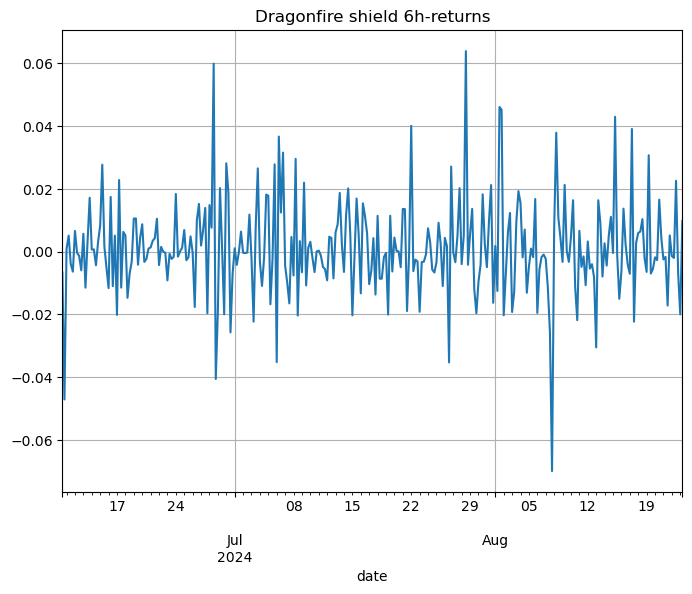

In [45]:
df_tr['simpRet_y'].plot(figsize=(8,6))
plt.title("{0} {1}-returns".format(item_name,freq))
plt.grid()
plt.show()

In [46]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_tr['simpRet_y'])
print('t-stat:{:.3f}'.format(adf_test[0]))
print('p-value:{:.4f}'.format(adf_test[1]))
print('lags:{}'.format(adf_test[2]))

t-stat:-15.845
p-value:0.0000
lags:1


In [47]:
from pmdarima.arima import auto_arima
auto_res = auto_arima(df_tr['simpRet_y'],seasonal=False,trace=True,max_p=15,max_q=15)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1651.094, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1643.440, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1643.795, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1645.148, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1649.697, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1651.445, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1647.715, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1653.326, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1651.813, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1649.677, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1654.280, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1643.621, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1653.126, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1652.803, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0

In [48]:
p,d,q = auto_res.order

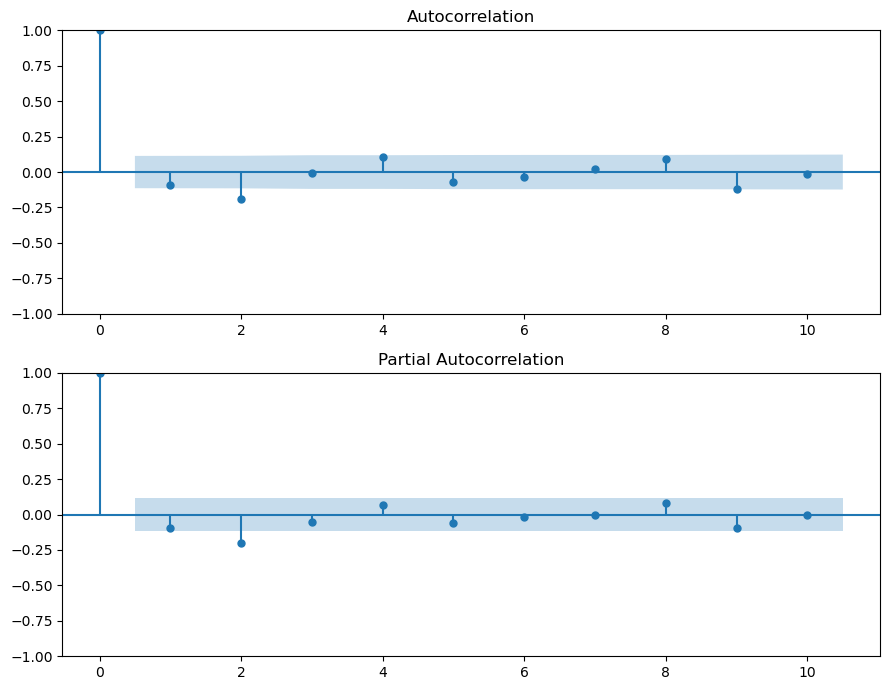

In [49]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_acf(df_tr['simpRet_y'],lags=10, ax=ax[0])
plot_pacf(df_tr['simpRet_y'],lags=10, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

What features to include in forecasting price?
- order imbalance (+ lags)
- lagged returns
- TA indicators
  - RSI
  - MACD
  - SMA
  - LMA

In [50]:
lagged_rets = 5
RSI_window = 10
MACD_short = 4
MACD_long = 16

df_tr = osrs_GE.compute_features(df_tr,lagged_rets=lagged_rets,RSI_window=RSI_window,
                                 MACD_short = MACD_short,
                                 MACD_long = MACD_long)

df_tr = df_tr.dropna()

/Users/codycao/Documents/Data projects/OSRS GE/osrs_GE.py:313: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['simpRet_'+str(k)] = df['simpRet_y'].shift(k)
/Users/codycao/Documents/Data projects/OSRS GE/osrs_GE.py:313: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['simpRet_'+str(k)] = df['simpRet_y'].shift(k)
/Users/codycao/Documents/Data projects/OSRS GE/osrs_GE.py:313: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [51]:
df_tr.shape

(286, 14)

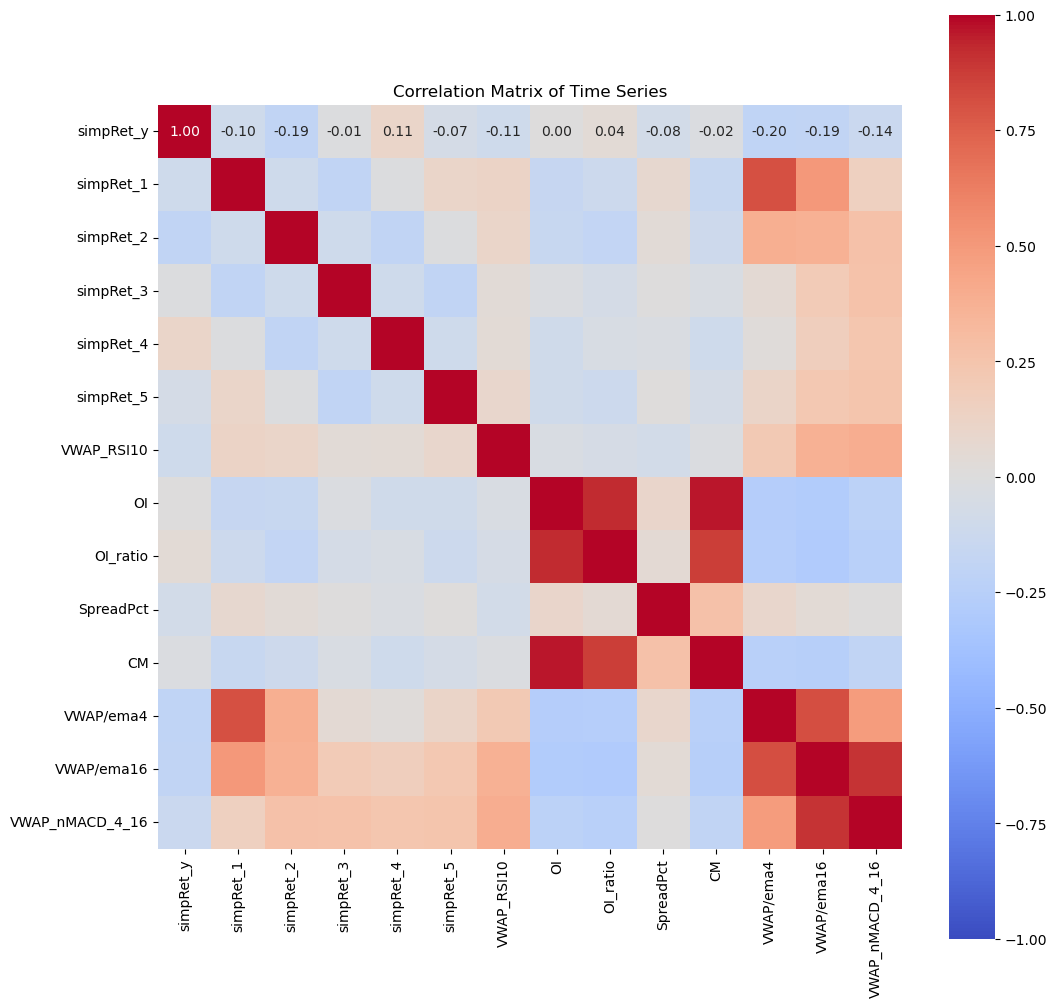

In [52]:
corr_matrix = df_tr.corr()

plt.figure(figsize=(12,12))

sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',square=True,vmin=-1,vmax=1)

plt.title('Correlation Matrix of Time Series')
plt.show()

# Return forecasting

## Feature selection for linear models

In [53]:
## Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

X = df_tr.drop('simpRet_y',axis=1).values
y = df_tr['simpRet_y'].values

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()
# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
alpha = lasso_cv.best_params_['alpha']
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [54]:
names=df_tr.drop("simpRet_y", axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['simpRet_1' 'simpRet_2' 'simpRet_3' 'simpRet_4' 'simpRet_5' 'VWAP_RSI10'
 'OI' 'OI_ratio' 'SpreadPct' 'CM' 'VWAP/ema4' 'VWAP/ema16'
 'VWAP_nMACD_4_16']


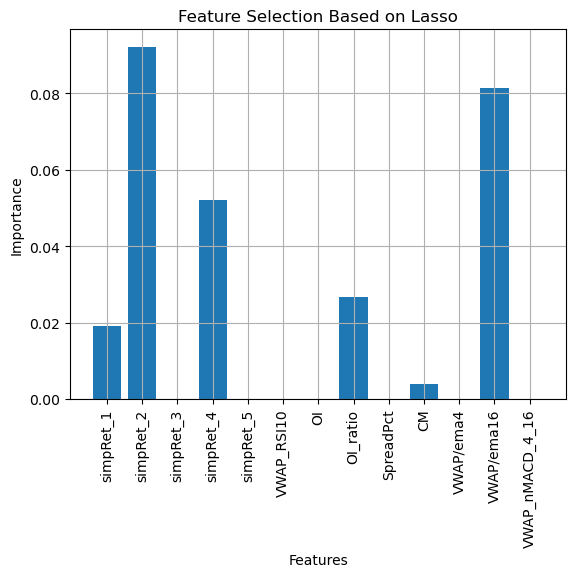

In [55]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X, y)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [56]:
# Subsetting the features that are relevant.
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures. 
feature_subset=np.append(feature_subset, 'simpRet_y')
print("Selected Columns: {}".format(feature_subset))

Selected Feature Columns: ['simpRet_1' 'simpRet_2' 'simpRet_4' 'OI_ratio' 'CM' 'VWAP/ema16']
Selected Columns: ['simpRet_1' 'simpRet_2' 'simpRet_4' 'OI_ratio' 'CM' 'VWAP/ema16'
 'simpRet_y']


In [57]:
df_tr_new = df_tr[feature_subset]
df_tr_new.head()

,simpRet_1,simpRet_2,simpRet_4,OI_ratio,CM,VWAP/ema16,simpRet_y
date,,,,,,,
2024-06-13 00:00:00,-0.005970,-0.001374,0.006588,-0.006160,-0.032398,0.989546,0.005685
2024-06-13 06:00:00,0.005685,-0.005970,-0.000367,0.375587,1.061199,0.995900,-0.011487
2024-06-13 12:00:00,-0.011487,0.005685,-0.001374,0.033755,0.261632,0.986705,0.003358
2024-06-13 18:00:00,0.003358,-0.011487,-0.005970,0.117199,1.248510,0.991427,0.017145
2024-06-14 00:00:00,0.017145,0.003358,0.005685,0.128015,1.296571,1.007246,0.000640


In [117]:
def iterative_testing(df,y_col,model=LinearRegression(),start_point=10):
    X_tr = df.drop(y_col,axis=1).values
    y_tr = df[y_col].values
    feature_shape = X_tr.shape[1]
    start_point = max(feature_shape+5,start_point)
    errors = []
    preds = []
    obs = []
    index = []
    
    for i in range(start_point,X_tr.shape[0]-1):
        # train on data up to i-1
        _X = X_tr[:i]
        _y = y_tr[:i]
        model_fit = model.fit(_X,_y)
        
        # predict i
        x_predict = X_tr[[i]]
        y_hat = model_fit.predict(x_predict)[0]
        y_obs = y_tr[i]
        
        # record errors
        errors.append(y_obs - y_hat)
        preds.append(y_hat)
        obs.append(y_obs)
        
        index.append(df.index[i])
    
    df_err = pd.DataFrame({'errors': errors,
                           'predicted': preds,
                           'observed': obs}, index=index)
    
    df_err[['predicted','observed']].plot(figsize=(8,6))
    plt.ylabel("% return")
    plt.grid()
    plt.title('Predicted vs. Actual returns over time')
    plt.show()
    print('\n')
    
    df_err.plot(x='predicted', y='observed', style='o',figsize=(8,6))
    plt.grid()
    plt.xlabel('Predicted returns')
    plt.ylabel('Actual returns')
    plt.title('Predicted vs. Actual returns')
    plt.show()
    print('\n')
    
    df_err.plot(x='observed', y='errors', style='o',figsize=(8,6))
    plt.grid()
    plt.xlabel('Actual returns')
    plt.ylabel('Prediction error')
    plt.title('Error vs. Actual returns')
    plt.show()
    
    reg_eploss = eploss(df_err['predicted'],df_err['observed']).mean()
    reg_mse = (df_err['errors']**2).mean()
    print("Mean EPLoss: ", reg_eploss)
    print("MSE: ", reg_mse)
    return df_err

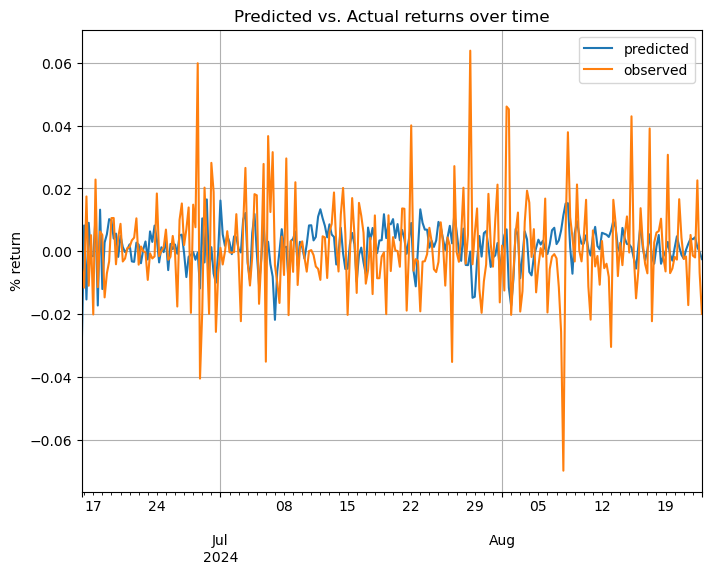

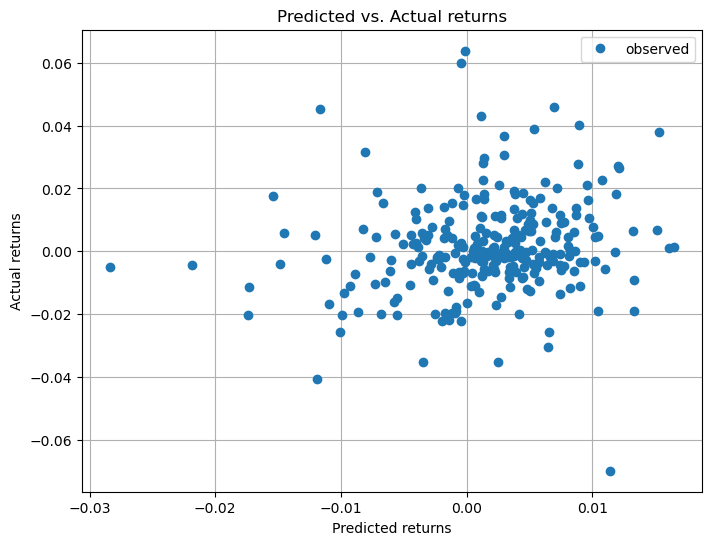

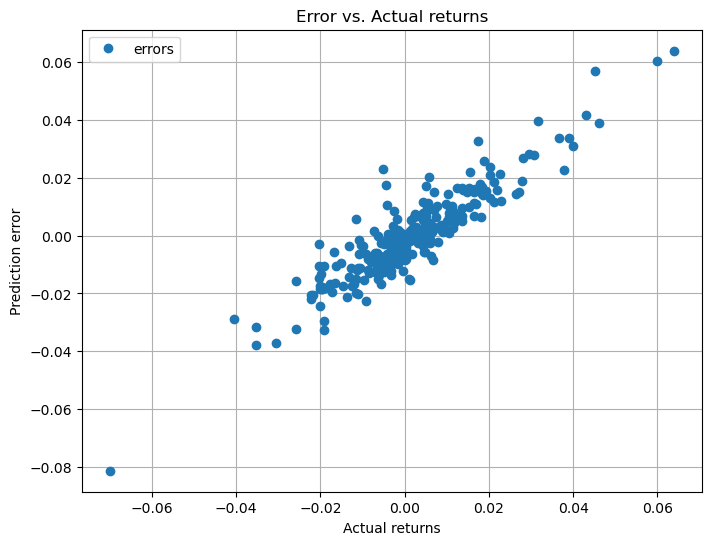

Mean EPLoss:  0.0012322490377049355
MSE:  0.00023879302708453446


In [118]:
model = LinearRegression()
#linear_reg_res = osrs_GE.iterative_testing(df_tr_new,'simpRet_y',model=model)
lr_train_res = iterative_testing(df_tr_new,'simpRet_y',model=model)

In [108]:
start_point = 10

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

arima_result = osrs_GE.ARIMA_CV_SCORE(df_tr_new['simpRet_y'],order=(p,d,q),start_point=start_point,
                                     custom_scorer=eploss)

In [109]:
print("ARIMA mean EPloss: ",arima_result['custom_scores'].mean())
print("ARIMA MSE: ",(arima_result['errors']**2).mean())

ARIMA mean EPloss:  0.0011936220352767655
ARIMA MSE:  0.000231693025275662


## Reframing the problem as classification for an investing strategy

In [64]:
trading_results = {}

In [65]:
# defining the % return threshold for trading strategy
# buy when pred > .005, sell when pred < -.0075

q_b , q_s = .005,-.0075

df_tr['signal'] = 1.0*(df_tr['simpRet_y'] > q_b) - (df_tr['simpRet_y'] < q_s)

In [66]:
df_tr['signal'].value_counts()

signal
 0.0    133
 1.0     95
-1.0     58
Name: count, dtype: int64

### revisiting linear regression as a classifier

In [125]:
lr_train_res['signal'] = 1.0*(lr_train_res['predicted']>q_b) - (lr_train_res['predicted'] < q_s)

lr_train_res = lr_train_res.join(df['VWAP'])
lr_train_res = lr_train_res.rename({'VWAP':'VWAP_trade'},axis=1)

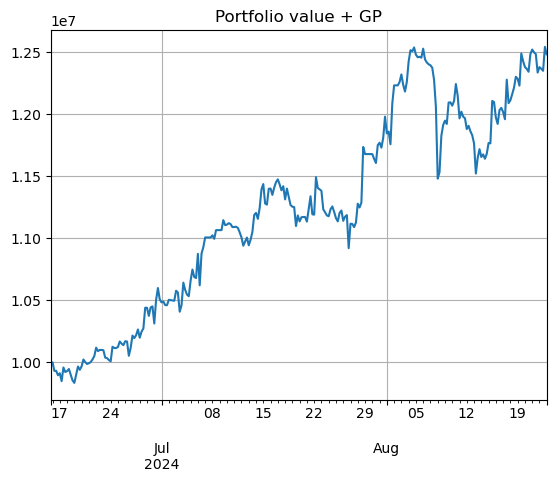

            inventory         stack  total_portfolio
2024-08-23        2.0  3.810332e+06     1.247937e+07


In [126]:
trading_results['lin_reg'] = osrs_GE.trading_strategy_pnler(lr_train_res,max_allowable=2,start_stack = 10e6)
print(trading_results['lin_reg'].tail(1))

#### On the test set

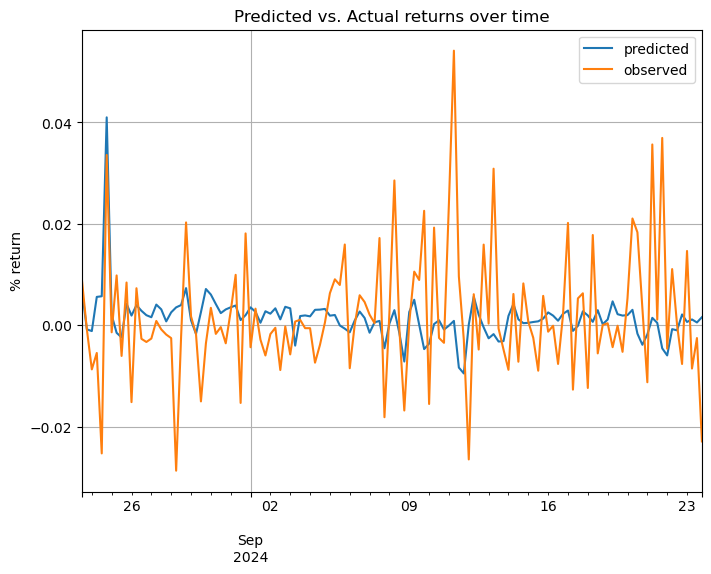

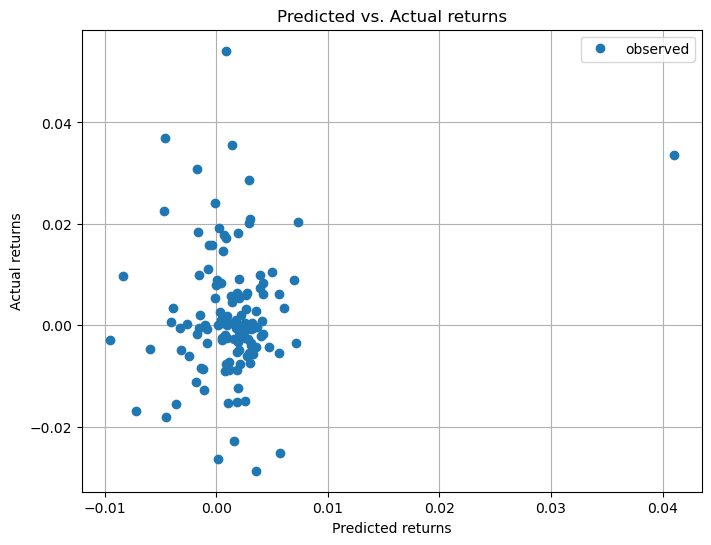

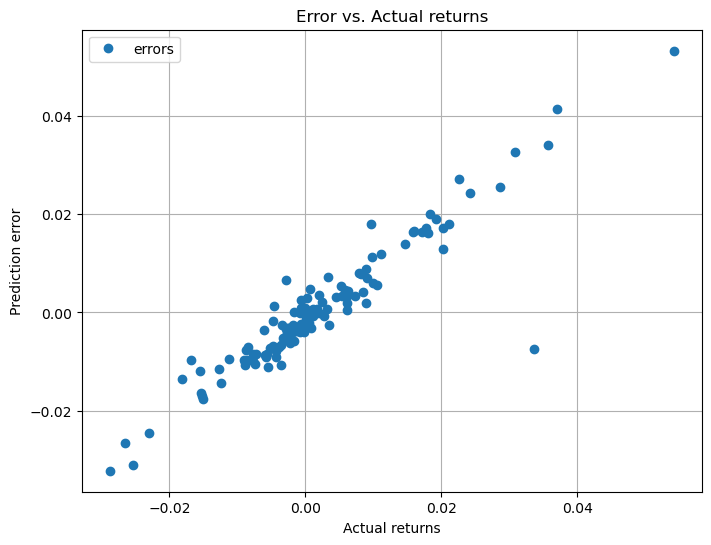

Mean EPLoss:  0.000829885966025864
MSE:  0.0001607703578641029


In [130]:
df_copy = df.copy()
df_copy = osrs_GE.compute_features(df_copy,lagged_rets=lagged_rets,RSI_window=RSI_window,
                                 MACD_short = MACD_short,
                                 MACD_long = MACD_long)


df_copy = df_copy.dropna()[feature_subset]
lr_test_res = iterative_testing(df_copy,'simpRet_y',model=LinearRegression(),start_point = df_tr.shape[0])

lr_test_res['signal'] = 1.0*(lr_test_res['predicted']>q_b) - (lr_test_res['predicted'] < q_s)
lr_test_res = lr_test_res.join(df['VWAP'])

lr_test_res = lr_test_res.rename({'VWAP':'VWAP_trade'},axis=1)

In [139]:
lr_test_res['signal'].value_counts()

signal
 0.0    115
 1.0      9
-1.0      2
Name: count, dtype: int64

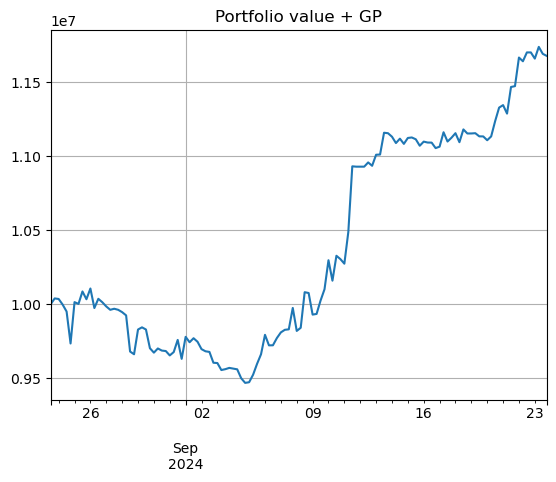

inventory          1.000000e+00
stack              6.246547e+06
total_portfolio    1.167565e+07
Name: 2024-09-23 18:00:00, dtype: float64


In [134]:
trading_results['lin_reg_test'] = osrs_GE.trading_strategy_pnler(lr_test_res,max_allowable=2,start_stack = 10e6)
print(trading_results['lin_reg_test'].iloc[-1])

<Axes: xlabel='date'>

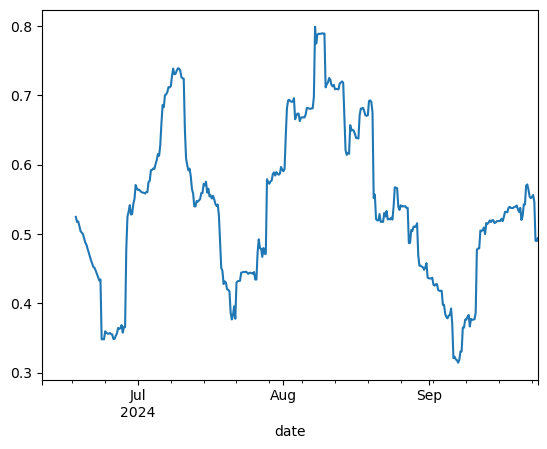

In [144]:
(df['simpRet_y'].rolling(window=50,min_periods=30).std()*np.sqrt(365)*2).plot()

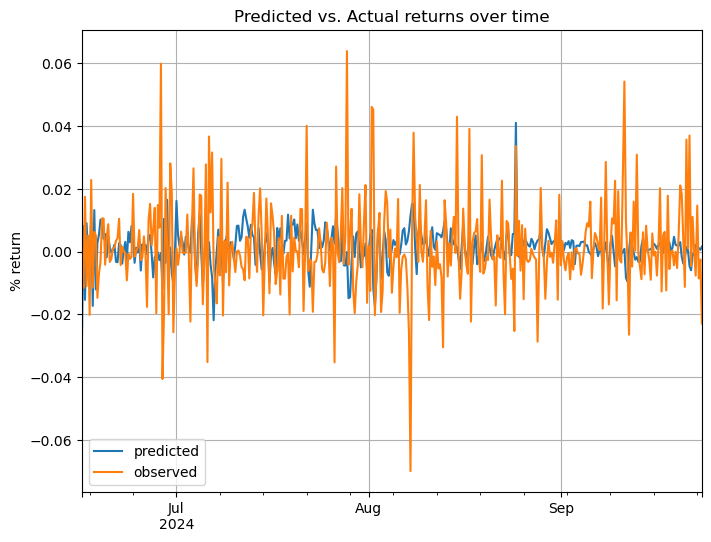

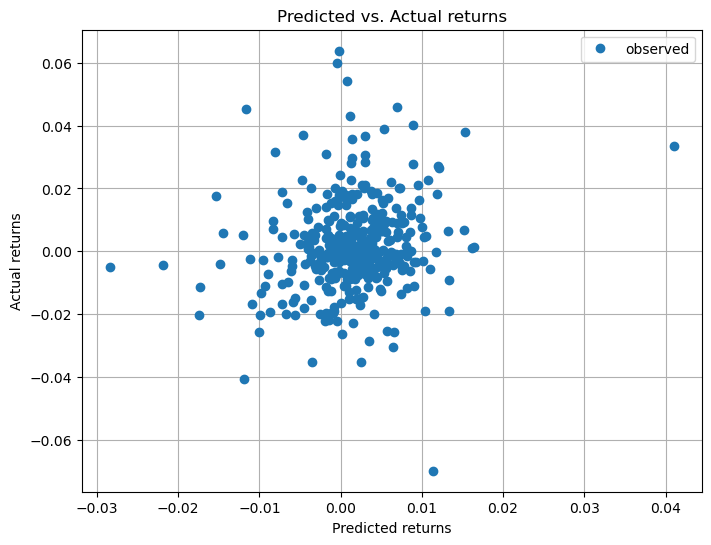

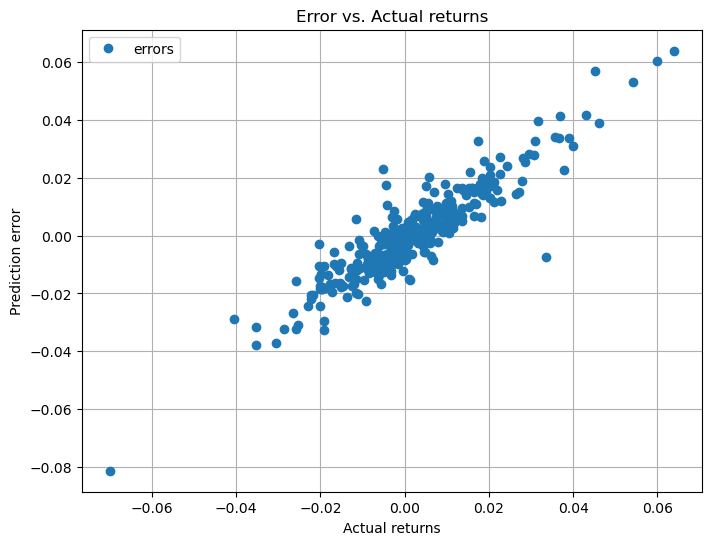

Mean EPLoss:  0.001103038353597806
MSE:  0.00021372518163967046


In [148]:
lr = iterative_testing(df_copy,'simpRet_y',model=LinearRegression(),start_point = 10)

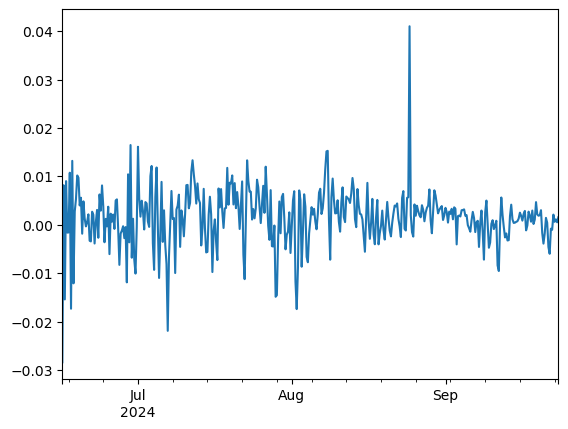

In [150]:
lr['predicted'].plot()
plt.show()